Think I have a nice big high-quality dataset now.

Let's start to lay the framework for fine-tuning a DINO model to perform multiclass classification.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# os.path.join(CLIP_FRAMES_FOLDER, LABEL_ENCODER_FILENAME)
# path = '/home/rocus/Documents/john/grepl/clip_frames/label_encoder.pkl'
path = '/home/rocus/Documents/john/grepl/clip_frames/filtered_label_encoder.pkl'

import pickle

label_encoder = pickle.load(open(path, 'rb'))
print(len(label_encoder.classes_))

1067


In [3]:
labels_of_interest = [
    "#butterflyguard",
    "#triangle",
    "#frontheadlock",
    "#legentanglement",
    "#singleleg",
    "#armbar",
    "#submission",
]
labels_of_interest_indices = dict(zip(
    labels_of_interest,
    label_encoder.transform(labels_of_interest).tolist()
))
labels_of_interest_indices

{'#butterflyguard': 132,
 '#triangle': 971,
 '#frontheadlock': 332,
 '#legentanglement': 552,
 '#singleleg': 854,
 '#armbar': 56,
 '#submission': 911}

Video Tensor Size: torch.Size([30, 3, 224, 224])


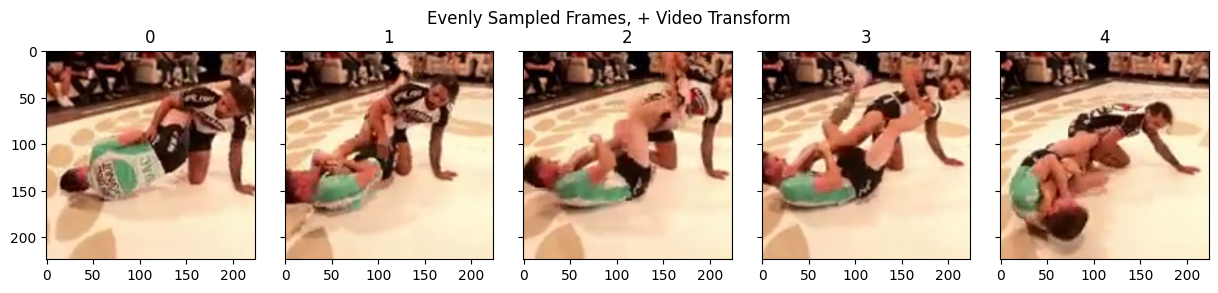

In [4]:
from grepl.processing.generate_annotations import (
    CLIP_FRAMES_FOLDER, ANNOTATION_FILENAME, ANNOTATION_CSV_FILENAME, LABEL_ENCODER_FILENAME
)
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from grepl.processing.videos_to_frames import FILE_TEMPLATE
from grepl.processing.video_dataset import  VideoFrameDataset, ImglistToTensor
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os

train_annotation_file = os.path.join(CLIP_FRAMES_FOLDER, "annotations_filtered_train.txt")
val_annotation_file = os.path.join(CLIP_FRAMES_FOLDER, "annotations_filtered_valid.txt")
test_annotation_file = os.path.join(CLIP_FRAMES_FOLDER, "annotations_filtered_test.txt")

# label_encoder = pickle.load(open(os.path.join(CLIP_FRAMES_FOLDER, LABEL_ENCODER_FILENAME), 'rb'))

# """ DEMO 1 WITHOUT IMAGE TRANSFORMS """
# dataset = VideoFrameDataset(
#     root_path=CLIP_FRAMES_FOLDER,
#     annotationfile_path=train_annotation_file,
#     num_segments=30,
#     frames_per_segment=1,
#     imagefile_template=FILE_TEMPLATE,
#     transform=None,
#     test_mode=False
# )

# sample = dataset[0]  # take first sample of dataset 
# frames = sample[0]   # list of PIL images
# label = sample[1]    # integer label

# for image in frames:
#     plt.imshow(image)
#     plt.title(label)
#     plt.show()
#     plt.pause(0.1)

# NEW_SIZE = 240  # Resize to this size before center-cropping
NEW_SIZE = 224  # Resize to this size before center-cropping

preprocess = transforms.Compose([
    ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    # resize to 224 and then center-crop, as woctezuma points out: 
    # https://github.com/facebookresearch/dinov2/issues/86#issuecomment-1536019590
    # (this is almost certainly extremely common)
    transforms.Resize(NEW_SIZE, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(NEW_SIZE),
])

dataset = VideoFrameDataset(
    root_path=CLIP_FRAMES_FOLDER,
    annotationfile_path=train_annotation_file,
    num_segments=30,
    frames_per_segment=1,
    imagefile_template=FILE_TEMPLATE,
    transform=preprocess,
    test_mode=False
)

sample = dataset[2]
frame_tensor = sample[0]  # tensor of shape (NUM_SEGMENTS*FRAMES_PER_SEGMENT) x CHANNELS x HEIGHT x WIDTH
label = sample[1]  # integer label

def plot_video(rows, cols, frame_list, plot_width, plot_height, title: str):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        # im is [C, H, W], need to transpose to [H, W, C] for matplotlib
        ax.imshow(im.permute(1, 2, 0))
        ax.set_title(index)
    plt.suptitle(title)
    plt.show()
print('Video Tensor Size:', frame_tensor.size())

plot_video(rows=1, cols=5, frame_list=frame_tensor, plot_width=15., plot_height=3.,
            title='Evenly Sampled Frames, + Video Transform')



In [5]:
len(label)

1067

In [6]:
dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=2**5,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("\nMulti-Label Example")
for epoch in range(10):
    for batch in dataloader:
        """
        Insert Training Code Here
        """
        video_batch, label_batch = batch
        # video_batch, (labels1, labels2, labels3) = batch

        print("Video Batch Tensor Size:", video_batch.size())
        print(f"# possible labels: {len(label_batch)}")
        print(f"Number of positive labels per sample: {sum(label_batch)}")
        # print("Labels1 Size:", labels1.size())  # == batch_size
        # print("Labels2 Size:", labels2.size())  # == batch_size
        # print("Labels3 Size:", labels3.size())  # == batch_size

        break
    break


Multi-Label Example


Video Batch Tensor Size: torch.Size([32, 30, 3, 224, 224])
# possible labels: 1067
Number of positive labels per sample: tensor([14, 10, 13,  5,  1, 10,  8,  4,  5,  3, 11,  4,  6,  4,  3,  4,  3, 10,
         3,  6,  3,  5,  2,  2,  4,  5,  2,  4,  7,  6,  4,  5])


In [7]:
# BASE_MODEL = "dinov2_vits14_reg"
# # BASE_MODEL = "dinov2_vitl14_reg"
# dino = torch.hub.load('facebookresearch/dinov2', BASE_MODEL)
# dino

from ultralytics import YOLO

# model = YOLO("yolo11l-pose.pt")

# BASE_MODEL = "yolo11n-pose.pt"
BASE_MODEL = "yolo11x-pose.pt"

yolo_backbone = YOLO(BASE_MODEL)

In [8]:
video_batch[0].shape

torch.Size([30, 3, 224, 224])

In [9]:
video_batch[0].shape, video_batch.shape

(torch.Size([30, 3, 224, 224]), torch.Size([32, 30, 3, 224, 224]))

In [10]:
video_batch[0,0].shape

torch.Size([3, 224, 224])

In [11]:
# dino.forward_features(video_batch[0])["x_norm_clstoken"].shape
EMBED_KW = {"embed": [22]}
embed_results = yolo_backbone.predict(
    # source="/home/rocus/Documents/john/grepl/clips/_-8tqh2Y9Zg_85_30.mp4.mp4",
    video_batch[0:3, 0],
    # embed=[22, 23]
    **EMBED_KW
)
len(embed_results)
FEATURE_DIM = embed_results[0].shape[-1]
FEATURE_DIM

768

In [12]:
len(embed_results), torch.stack(embed_results, dim=0).shape

(3, torch.Size([3, 768]))

In [13]:
# check if cuda is available
torch.cuda.is_available()

True

In [14]:
import torch
from torch import nn
# from grepl.layers import Mlp, PatchEmbed, SwiGLUFFNFused, MemEffAttention, NestedTensorBlock as Block
from grepl.layers.mlp import Mlp
from grepl.layers.attention import Attention
from grepl.layers.block import Block
from grepl.models.max_classifier import (
    MaxFrameClassifier, MaxFramePatchEmbeddingsClassifier, MaxFrameTransformerHeadClassifier
)

class YoloMaxFrameTransformerHeadClassifier(nn.Module):
    """Add another transformer block"""
    
    def __init__(self, backbone, num_classes, feature_dim=384, n_blocks=2, embed_kw=None):
        super().__init__()
        self.backbone = backbone
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        self.embed_kw = embed_kw
        if embed_kw is None:
            self.embed_kw = {"embed": [22]}  # default to layer 22 embeddings
        # add a transformer block before the final classifier
        blocks_list = [
            Block(
                dim=feature_dim,
                num_heads=8,
                mlp_ratio=4.0,
                qkv_bias=True,
                drop_path=0.1,
            )
            for _ in range(n_blocks)
        ]
        # self.transformer_blocks = nn.Sequential(*blocks_list)
        self.transformer_blocks = nn.ModuleList(blocks_list)
        self.classifier = nn.Linear(in_features=feature_dim, out_features=num_classes, bias=True)
        # learnable parameters for the classifier head
        # self.feature_frame_decay = nn.Parameter(torch.zeros(1, 1, feature_dim))
        self.logit_frame_decay = nn.Parameter(torch.zeros(1, 1, 1))

    def forward(self, images):
        batch_size, n_frames_per_video, channels, height, width = images.shape
        images_flattened = images.flatten(0, 1)  # flatten batch and segments
        x = self.backbone.predict(
            images_flattened,
            **self.embed_kw,
            verbose=False,
        )
        x = torch.stack(x, dim=0)  # list of tensors to tensor
        features = x.unflatten(0, [batch_size, n_frames_per_video]) # [batch, n_frames, feature_dim]
        # feature_frame_scale = self.feature_frame_decay * torch.arange(n_frames_per_video, device=features.device).unsqueeze(0).unsqueeze(-1) 
        # feature_frame_scale = feature_frame_scale.exp()
        # features *= feature_frame_scale
        logits = self.classifier(features) # [batch, n_frames, num_classes]
        logit_scale = self.logit_frame_decay * torch.arange(n_frames_per_video, device=logits.device).unsqueeze(0).unsqueeze(-1) 
        logit_scale = logit_scale.exp()
        logits = logits * logit_scale
        max_logits = logits.max(dim=1)[0]
        return max_logits


# num_classes = len(label_encoder.classes_)
num_classes = len(labels_of_interest)
model = YoloMaxFrameTransformerHeadClassifier(yolo_backbone, num_classes, feature_dim=FEATURE_DIM, embed_kw=EMBED_KW)
DEVICE = "cuda:1"
_ = model.to(DEVICE)

/home/rocus/Documents/john/grepl/src/grepl/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/rocus/Documents/john/grepl/src/grepl/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [15]:
model(video_batch[0:3])

tensor([[ 0.1426,  0.0340,  0.4296,  0.2251,  0.2847,  0.1510,  0.0570],
        [ 0.0291,  0.0586,  0.3533,  0.0932,  0.4163,  0.1289, -0.0263],
        [ 0.1475,  0.0926,  0.2594,  0.0525,  0.3090,  0.1429,  0.0087]], device='cuda:1', grad_fn=<MaxBackward0>)

In [16]:
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
NUM_CLASSES = model.num_classes
T_MAX = min(NUM_EPOCHS, 10)
CLASSIFIER_NAME = str(model.__class__)
NUM_EPOCHS, LEARNING_RATE, CLASSIFIER_NAME

(100, 0.0001, "<class '__main__.YoloMaxFrameTransformerHeadClassifier'>")

In [17]:
from torch import optim, nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # some guy on reddit said this is the magical learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=T_MAX, eta_min=1e-7)

In [18]:
import wandb

wandb.login()
wandb.init(
    project="grepl",
    config={
        "base_model": BASE_MODEL,
        "learning_rate": LEARNING_RATE,
        "num_epochs": NUM_EPOCHS,
        "classifier_name": CLASSIFIER_NAME,
        "t_max": T_MAX,
        "num_classes": NUM_CLASSES, # not quite binary but small
        "batch_size": dataloader.batch_size,
    },
)


wandb: Currently logged in as: john-leonardo-curcio to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [19]:
# ugly
labels_of_interest_labels, labels_of_interest_mask = zip(*sorted(labels_of_interest_indices.items()))
print(labels_of_interest_indices)
labels_of_interest_labels, labels_of_interest_mask

{'#butterflyguard': 132, '#triangle': 971, '#frontheadlock': 332, '#legentanglement': 552, '#singleleg': 854, '#armbar': 56, '#submission': 911}


(('#armbar',
  '#butterflyguard',
  '#frontheadlock',
  '#legentanglement',
  '#singleleg',
  '#submission',
  '#triangle'),
 (56, 132, 332, 552, 854, 911, 971))

In [ ]:
from tqdm import tqdm
from sklearn.metrics import log_loss


for epoch in range(NUM_EPOCHS):
    pbar = tqdm(enumerate(dataloader))
    for idx, (video_batch, label_batch) in pbar:
        # the dataloader returns a list of NUM_CLASSES tensors, each with torch.Size([BATCH_SIZE])
        # and we'd rather have a single tensor of shape [BATCH_SIZE, NUM_CLASSES]
        # label_batch = torch.stack(label_batch).T
        label_batch = torch.stack(label_batch)[labels_of_interest_mask,:].T # restrict to labels of interst
        video_batch = video_batch.to(DEVICE)
        label_batch = label_batch.to(DEVICE)
        optimizer.zero_grad() # TODO I don't fully understand this, but it seems to be necessary
        # i believe this is disabling gradient accumulation. but i thought that was a good thing!
        
        logits = model(video_batch)
        loss = criterion(logits, label_batch.float())
        loss.backward()
        optimizer.step()
        
        if idx % 10 == 0:
            # print(f"Epoch {epoch+1}/{num_epochs}, Step {idx}, Loss: {loss.item():.4f}")
            pbar.set_description(f"Epoch {epoch+1}/{NUM_EPOCHS}, Step {idx}, Loss: {loss.item():.4f}")
    
        if idx % 100 == 0:
            # calculate accuracy per class
            with torch.no_grad():
                logits = model(video_batch)
                probs = torch.sigmoid(logits)
                prob_std = probs.float().std(dim=0).cpu().numpy()
                
                entropy_of_interest = {
                    k: log_loss(
                                y_true=label_batch[:, i].cpu().numpy(),
                                y_pred=probs[:, i].cpu().numpy(),
                                labels=[0, 1]  # specify labels for log_loss
                            )
                    for i, k in enumerate(labels_of_interest_labels)
                }
                
                pbar.set_postfix(
                    {
                        "prob_std_mean": f"{prob_std.mean():.4f}",
                        "prob_std_max": f"{prob_std.max():.4f}",
                        "loss": f"{loss.item():.4f}",
                        **{
                            k: f"{ll:.4f}" for k, ll in entropy_of_interest.items()
                        }
                    }
                )
    scheduler.step()

0it [00:00, ?it/s]

Epoch 1/100, Step 380, Loss: 0.1909: : 386it [08:53,  1.38s/it, prob_std_mean=0.0285, prob_std_max=0.0330, loss=0.2777, #armbar=0.2207, #butterflyguard=0.1841, #frontheadlock=0.3043, #legentanglement=0.4764, #singleleg=0.3989, #submission=0.1865, #triangle=0.1716]
Epoch 2/100, Step 380, Loss: 0.1540: : 386it [08:51,  1.38s/it, prob_std_mean=0.0217, prob_std_max=0.0285, loss=0.1978, #armbar=0.0442, #butterflyguard=0.0412, #frontheadlock=0.2202, #legentanglement=0.2562, #singleleg=0.6200, #submission=0.1616, #triangle=0.0405]
Epoch 3/100, Step 380, Loss: 0.1829: : 386it [08:51,  1.38s/it, prob_std_mean=0.0194, prob_std_max=0.0390, loss=0.1814, #armbar=0.0273, #butterflyguard=0.2595, #frontheadlock=0.0423, #legentanglement=0.2352, #singleleg=0.4026, #submission=0.1584, #triangle=0.1445]
Epoch 4/100, Step 380, Loss: 0.2128: : 386it [08:52,  1.38s/it, prob_std_mean=0.0204, prob_std_max=0.0518, loss=0.1824, #armbar=0.1276, #butterflyguard=0.2852, #frontheadlock=0.0371, #legentanglement=0.373

In [ ]:
# torch.stack(label_batch)[:,labels_of_interest_mask].shape


In [1]:
model.logit_frame_decay # TODO I expect this to be negative

NameError: name 'model' is not defined

In [ ]:
label_encoder.inverse_transform(labels_of_interest_mask)

array(['#armbar', '#butterflyguard', '#frontheadlock', '#legentanglement', '#singleleg', '#submission', '#triangle'], dtype='<U32')

In [ ]:
# look at some training predictions
import numpy as np
import pandas as pd

label_batches = []
pred_batches = []

def decode_dummy(labels_vec: np.ndarray, label_encoder):
    dummy_inds = np.where(labels_vec > 0)[0]
    return label_encoder.inverse_transform(dummy_inds)

pbar = tqdm(enumerate(dataloader), total=len(dataloader))

for idx, (video_batch, label_batch) in pbar:
    label_batch = torch.stack(label_batch).T
    video_batch = video_batch.to(DEVICE)
    # label_batch = label_batch.to(DEVICE)
    with torch.no_grad():
        logits = model(video_batch)
        probs = torch.sigmoid(logits)
        pred_batches.append(probs.cpu().numpy())
        # pred_batches.append(logits.cpu().numpy())
        label_batches.append(label_batch.numpy())
        


100%|██████████| 386/386 [08:47<00:00,  1.37s/it]


In [ ]:
pred_df = pd.DataFrame(
    np.vstack(pred_batches),
    columns=label_encoder.inverse_transform(labels_of_interest_mask)
)
label_df = pd.DataFrame(
    np.vstack(label_batches)[:,labels_of_interest_mask],
    columns=label_encoder.inverse_transform(labels_of_interest_mask)
)

In [ ]:
from sklearn.metrics import roc_auc_score

# # hey this is pretty good actually!
# for col in [
#     *labels_of_interest,
#     "#legentanglement",
#     "#singleleg",
#     "#armbar",
#     "#submission",
#     "#underhook",
# ]:
for col in labels_of_interest:
    col_idx = label_encoder.transform([col])[0]
    auc = roc_auc_score(label_df[col], pred_df[col])
    print(f"{col}: {auc:.4f}")

#butterflyguard: 0.5800
#triangle: 0.6247
#frontheadlock: 0.5806
#legentanglement: 0.6411
#singleleg: 0.7755
#armbar: 0.6308
#submission: 0.6773


In [ ]:
pred_df.std().sort_values(ascending=False).head(10)

#singleleg          0.060127
#submission         0.037063
#legentanglement    0.032244
#armbar             0.013055
#frontheadlock      0.011826
#triangle           0.010951
#butterflyguard     0.007231
dtype: float32

In [ ]:
# save model
torch.save(model.state_dict(), f"overfit_classifier_{NUM_EPOCHS}.pth")

# Validation set

Hey maybe we learned something?

In [ ]:
val_dataset = VideoFrameDataset(
    root_path=CLIP_FRAMES_FOLDER,
    annotationfile_path=val_annotation_file,
    num_segments=30,
    frames_per_segment=1,
    imagefile_template=FILE_TEMPLATE,
    transform=preprocess,
    test_mode=True
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=2**5,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader))

pred_batches = []
label_batches = []

for idx, (video_batch, label_batch) in pbar:
    label_batch = torch.stack(label_batch).T
    video_batch = video_batch.to(DEVICE)
    # label_batch = label_batch.to(DEVICE)
    with torch.no_grad():
        logits = model(video_batch)
        probs = torch.sigmoid(logits)
        pred_batches.append(probs.cpu().numpy())
        # pred_batches.append(logits.cpu().numpy())
        label_batches.append(label_batch.numpy())

val_pred_df = pd.DataFrame(
    np.vstack(pred_batches),
    columns=label_encoder.inverse_transform(labels_of_interest_mask)
)
val_label_df = pd.DataFrame(
    np.vstack(label_batches)[:,labels_of_interest_mask],
    columns=label_encoder.inverse_transform(labels_of_interest_mask)
)

100%|██████████| 56/56 [01:18<00:00,  1.41s/it]


In [ ]:
from sklearn.metrics import log_loss

for col in labels_of_interest:
    col_idx = label_encoder.transform([col])[0]
    auc = roc_auc_score(val_label_df[col], val_pred_df[col])
    ll = log_loss(y_true=val_label_df[col], y_pred=val_pred_df[col])
    print(f"{col}: AUC={auc:.4f}, LL={ll:.4f}")

#butterflyguard: AUC=0.4715, LL=0.0703
#triangle: AUC=0.5260, LL=0.0957
#frontheadlock: AUC=0.5944, LL=0.1139
#legentanglement: AUC=0.5876, LL=0.3366
#singleleg: AUC=0.7449, LL=0.3159
#armbar: AUC=0.6195, LL=0.0908
#submission: AUC=0.6176, LL=0.2030


In [ ]:
aug_val_pred_df = val_pred_df.merge(
    val_label_df,
    left_index=True, right_index=True,
    suffixes=("_pred", "")
)
aug_val_pred_df["clip_frames_path"] = [r.path for r in val_dataset.video_list]
aug_val_pred_df["clip_filename"] = aug_val_pred_df["clip_frames_path"].str[len("/home/rocus/Documents/john/grepl/clip_frames/"):]
aug_val_pred_df.head()

,#armbar_pred,#butterflyguard_pred,#frontheadlock_pred,#legentanglement_pred,#singleleg_pred,#submission_pred,#triangle_pred,#armbar,#butterflyguard,#frontheadlock,#legentanglement,#singleleg,#submission,#triangle,clip_frames_path,clip_filename
0,0.032893,0.021356,0.031405,0.127184,0.081688,0.091922,0.030135,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/j...,j776TasdwSk_189_30
1,0.019009,0.011424,0.028609,0.155979,0.053750,0.084837,0.016995,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/Y...,Yy6IfZ34bHA_114_30
2,0.023546,0.009111,0.026421,0.158632,0.063144,0.062152,0.014859,0,0,0,1,0,1,0,/home/rocus/Documents/john/grepl/clip_frames/7...,7MWQvtPu0IM_392_30
3,0.009821,0.007995,0.028392,0.089921,0.106824,0.053027,0.010416,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/I...,IyneYOMCvI0_30183_30
4,0.059720,0.029120,0.040820,0.131796,0.064289,0.142111,0.048400,1,0,0,0,0,1,0,/home/rocus/Documents/john/grepl/clip_frames/H...,HiNsdE4XoUo_132_30


In [ ]:
tag_to_try = "#legentanglement"

aug_val_pred_df.loc[aug_val_pred_df[tag_to_try] == 0].sort_values(by=f"{tag_to_try}_pred", ascending=False).head()

,#armbar_pred,#butterflyguard_pred,#frontheadlock_pred,#legentanglement_pred,#singleleg_pred,#submission_pred,#triangle_pred,#armbar,#butterflyguard,#frontheadlock,#legentanglement,#singleleg,#submission,#triangle,clip_frames_path,clip_filename
1671,0.026624,0.013729,0.019491,0.225044,0.040635,0.107649,0.023647,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/k...,kwv3DyVwlT8_316_30
1420,0.020346,0.010451,0.025205,0.219797,0.027247,0.072552,0.018656,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/K...,KB8GO0XzwuU_698_30
1685,0.033065,0.014669,0.026917,0.218797,0.028207,0.106208,0.026873,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/m...,mm3LjAxujsM_7281_30
31,0.037807,0.019573,0.033488,0.215711,0.095504,0.181487,0.031118,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/a...,a0lJu2xcYsA_614_30
1687,0.034759,0.022419,0.029678,0.208435,0.026079,0.151047,0.031518,0,0,0,0,0,0,0,/home/rocus/Documents/john/grepl/clip_frames/m...,mm3LjAxujsM_7249_30


In [ ]:
from IPython.display import Video

# thank god for this utility
Video("/home/rocus/Documents/john/grepl/clips/8DhKdCPpUbU_177_30.mp4")
# Video("/home/rocus/Documents/john/grepl/clips/e5hRJueLPJM_1093_30.mp4.mp4")

In [ ]:
aug_val_pred_df.to_csv("2025_09_02_validation_preds.csv", index=False)

Takeaways:

* the DINOv2 small model can overfit to training data (>0.99 ROC-AUC on all labels)
* Surprisingly hard to get the loss to dip much further
* The model is most likely paying a LOT of attention to the scenery cues. Obv knows single legs are much more common in wrestling than in BJJ. Mistook a RNC for a legentanglement (either that or it just recognized Andrew Tackett as a leglocker?)
* I would expect to get a lot of improvement by just stripping down to a representation which better isolates the factors I'm interested in. Depth maps or pose estimates.